# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

### Importing packages and loading dataframe

In [106]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import statsmodels.api as sm
from pandas import datetime

In [2]:
df = pd.read_csv('zillow_data.csv')

# Step 2: Data Preprocessing

In [5]:
def get_datetimes(df, x):
    """Takes in the dataframe (df) and the start column number (x) and returns 
    the column in datetime format
    """
    return pd.to_datetime(df.columns.values[x:], format='%Y-%m')

df.columns.values[7:] = get_datetimes(df, 7)

In [16]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 3: Reshape from Wide to Long Format

In [14]:
def melt_data(df):
    """Takes in the dataframe and melts it to arrange the data according to time. 
    Sets the index to the time/date and removes all other unnecessary parameters.
    """
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

long_df = melt_data(df)

In [17]:
long_df.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

In [33]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Let's take a look at our melted data and see what kind of distribution we have over time.

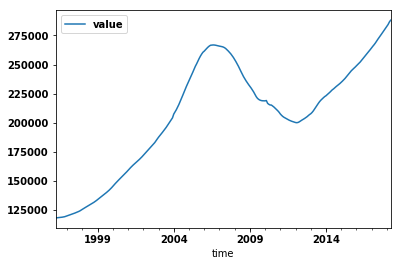

In [28]:
long_df.plot()

This doesn't look very stationary - let's run a Dicky Fuller test.

In [21]:
def dfuller(df, param):
    """Takes in the dataframe and parameter of interest and outputs the the 
    Dicky Fuller test results: test statistic, p-value, number of lags, 
    number of observations
    """
    dfuller = adfuller(df[param][1:-1])
    dfoutput = pd.Series(dfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    return dfoutput

In [22]:
dfuller(long_df, 'value')

Test Statistic                  -1.719639
p-value                          0.421023
#Lags Used                       2.000000
Number of Observations Used    260.000000
dtype: float64

As we can see, our Dicky Fuller p-value is not significant which means we do not have a stationary dataset. Let's difference our data and take a look again.

In [55]:
def difference(df, old_param, new_name):
    diff = df.diff().rename(index = str, columns = {old_param: new_name})
    return diff
diff1 = difference(long_df, 'value', 'one diff')[1:]

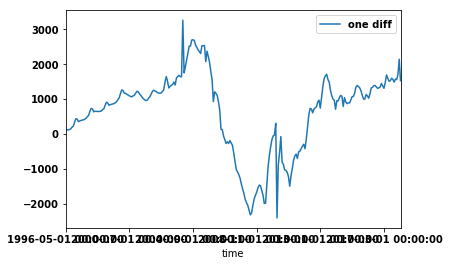

In [58]:
diff1.plot()

In [60]:
dfuller(diff1, 'one diff')

Test Statistic                  -2.434646
p-value                          0.132196
#Lags Used                      13.000000
Number of Observations Used    248.000000
dtype: float64

Ok, so we still aren't stationary. Let's difference one more time and take another look.

In [61]:
diff2 = difference(diff1, 'one diff', 'two diff')[1:]

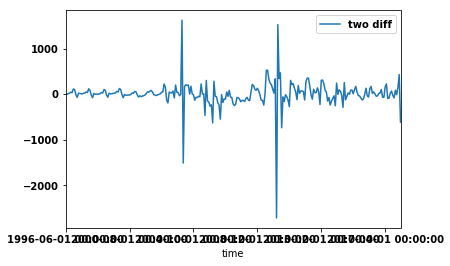

In [62]:
diff2.plot()

In [63]:
dfuller(diff2, 'two diff')

Test Statistic                 -20.906763
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    260.000000
dtype: float64

Much better! We have differenced twice which means our d value will be 2.

Now let's take a look at our autocorrelation and partial autocorrelation functions to determine our p and q values.

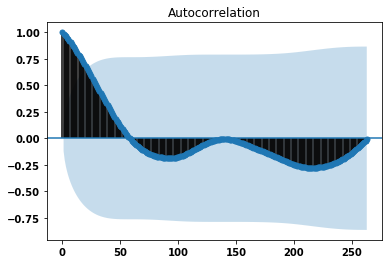

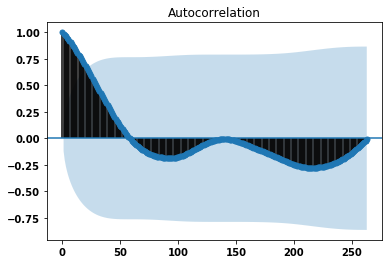

In [41]:
plot_acf(long_df[:-1], alpha = 0.05)

Kind of crowded, let's take a look at the first 25 lags. 

In [43]:
def acf(df, alpha, lags):
    return plot_acf(df[:-1], alpha = alpha, lags = lags)

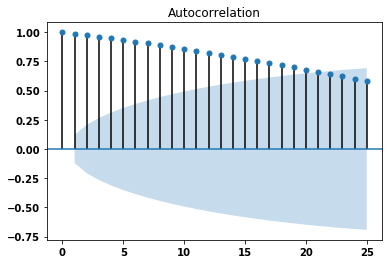

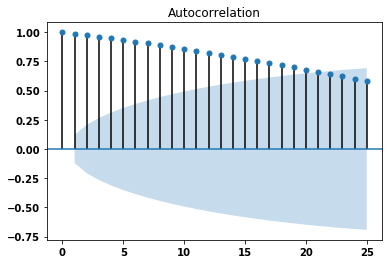

In [42]:
acf(long_df, 0.05, 25)

So we definitely have a geometric trend, but let's take a look at our partial autocorrelation function to see if anything is driving this autocorrelation.

In [64]:
def pacf(df, alpha, lags):
    return plot_pacf(df[:-1], alpha = alpha, lags = lags)

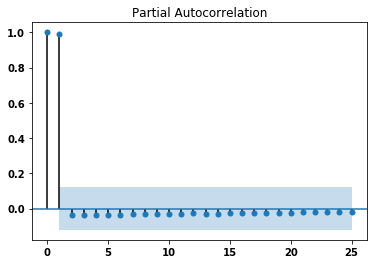

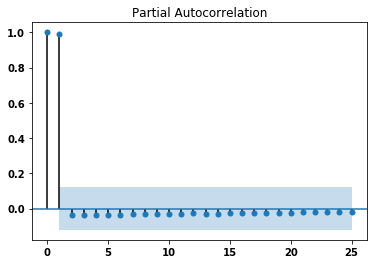

In [65]:
pacf(long_df, 0.05, 25)

Looks like our first partial autocorrelation is driving our autocorrelations. Using this information combined with the geometric trend of our autocorrelation, we can determine that our p = 1 and our q = 0.

Now let's take a look and see if we have any seasonality.

In [129]:
def seasonality(df):
    result = seasonal_decompose(long_df, model='additive')
    result.plot()
    plt.show()

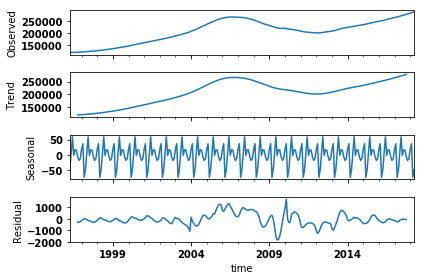

In [130]:
seasonality(long_df)

Looks like we do, so now we need to find our seasonal orders. We already know that our time series is separated by month so we can set our s = 12.

Let's iterate through all combinations up to an order of 3 and find our corresponding AIC values. We will then choose the lowest AIC value to pick our seasonality orders.

In [84]:
p = d = q = range(0, 4)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def seasonalorder(df):
    ans = []
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                        seasonal_order=combs,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            output = mod.fit()
            ans.append([combs, output.aic])
        except Exception as e:
            print(e) 
    ans_df = pd.DataFrame(ans, columns=['pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    return ans_df.loc[ans_df['aic'].idxmin()]

In [85]:
seasonalorder(long_df)

/Users/Natalie/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Natalie/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Natalie/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Natalie/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Natalie/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimizat

pdqs    (1, 2, 3, 12)
aic           3379.19
Name: 27, dtype: object

So we can see that our PQD and s values are: (1, 2, 3, 12)

In [86]:
pdq_baseline = (1, 2, 0)
PDQS_baseline = (1, 2, 3, 12)

In [89]:
print(len(long_df) * 0.8)
train = long_df[:212]
test = long_df[212:]

212.0


# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

Ok, now that we have our orders for our model, let's run it.

In [114]:
def sarimamodel(df, pdq, PDQs):
    SARIMA_MODEL = sm.tsa.statespace.SARIMAX(train,
                                order=pdq_baseline,
                                seasonal_order=PDQS_baseline,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    output = SARIMA_MODEL.fit()

    return output

In [122]:
def sarimadiag(df, pdq, PDQS):
    return sarimamodel(df, pdq, PDQS).summary(), sarimamodel(df, pdq, PDQS).plot_diagnostics(figsize=(15, 18))

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                  Statespace Model Results                                 
 Dep. Variable:                              value   No. Observations:                  212
 Model:             SARIMAX(1, 2, 0)x(1, 2, 3, 12)   Log Likelihood               -1144.759
 Date:                            Fri, 26 Jul 2019   AIC                           2301.518
 Time:                                    15:41:04   BIC                           2319.542
 Sample:                                04-01-1996   HQIC                          2308.841
                                      - 11-01-2013                                         
 Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1         -0.2830      0.056     -5.043      0.00

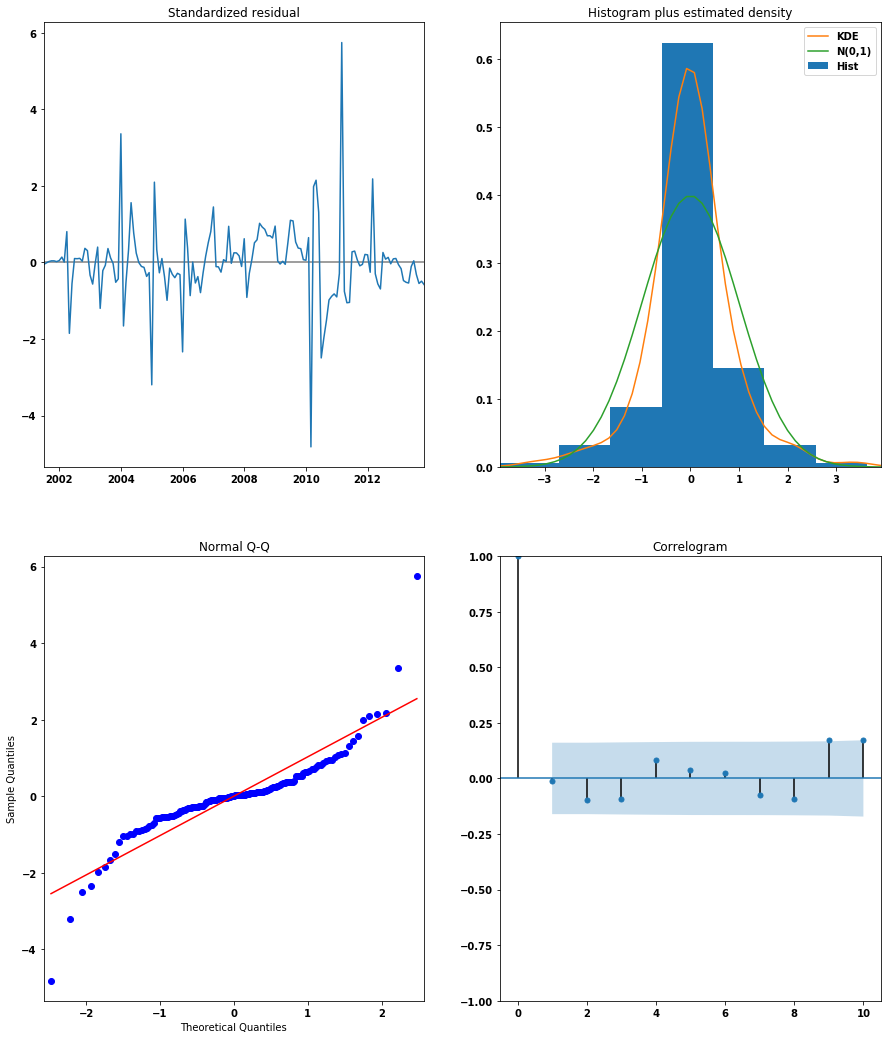

In [123]:
sarimadiag(test, pdq_baseline, PDQS_baseline)

In [127]:
start_index = datetime(1996, 4, 1)
end_index = datetime(2018, 4, 1)
def forecast(start, end, df, pdq, PDQS):
    forecast = sarimamodel(df, pdq, PDQS).predict(start=start, end=end)[1:]
    plt.plot(forecast)
    plt.plot(long_df)
    plt.show()

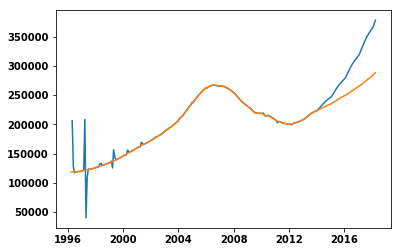

In [128]:
forecast(start_index, end_index, test, pdq_baseline, PDQS_baseline)

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.